In [2]:
%load_ext autoreload
%autoreload 2

Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import mean_squared_error
import pickle
import sys
import seaborn as sns

In [4]:
import os
os.chdir('../')
print(os.getcwd())

/home/jupyter/temp29Oct-Mok-83d98d1014e1d20c6c8ebd7aff4dcef05b6f1229/PRS-PM-ISY5002-GROUP5/SystemCode


In [5]:
from datapipeline_uc3 import Datapipeline

In [6]:
# Function to show various error measurement
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    mse = np.mean((forecast - actual)**2)  # MSE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    mmape = np.mean(np.abs(forecast - actual) / np.abs(forecast)) # modified mape
    #corr = np.corrcoef(forecast, actual)[0,1]   # corr
    #mins = np.amin(np.hstack([forecast[:,None], 
    #                          actual[:,None]]), axis=1)
    #maxs = np.amax(np.hstack([forecast[:,None], 
    #                          actual[:,None]]), axis=1)
    #minmax = 1 - np.mean(mins/maxs)             # minmax
    #acf1 = acf(fc-test)[1]                      # ACF1
    #return({'mape':mape, 'me':me, 'mae': mae, 
    #        'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
    #        'corr':corr, 'minmax':minmax})
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'mse':mse, 'rmse':rmse, 'mmape': mmape})

In [7]:
dpl = Datapipeline()

Read raw data from file

In [8]:
dict_hosp_filepaths = {
    'GHL': './Data Exploration/data/uc3/GHL_data_uc3.pkl',
    'MEH': './Data Exploration/data/uc3/MEH_data_uc3.pkl',
    'PEH': './Data Exploration/data/uc3/PEH_data_uc3.pkl',
    'PNH': './Data Exploration/data/uc3/PNH_data_uc3.pkl'}

In [9]:
raw_data_path = './Data Exploration/data/uc3/BillEstimate.csv'
dict_hosp_filepaths = dpl.transform_raw_data(raw_data_path, split_hosp=True)
print(dict_hosp_filepaths)

{'GHL': './Data Exploration/data/uc3/GHL_data_uc3.pkl', 'MEH': './Data Exploration/data/uc3/MEH_data_uc3.pkl', 'PNH': './Data Exploration/data/uc3/PNH_data_uc3.pkl', 'PEH': './Data Exploration/data/uc3/PEH_data_uc3.pkl'}


Creating a train and test dataset.

In [10]:
dict_X_train_file_paths = {}
dict_y_train_file_paths = {}
dict_X_test_file_paths = {}
dict_y_test_file_paths = {}
save_folder_path = None

for hosp in dict_hosp_filepaths:
    if save_folder_path is None:
        save_folder_path = os.path.dirname(dict_hosp_filepaths[hosp])
    X_train_file_paths, y_train_file_path, X_test_file_paths, y_test_file_path = dpl.transform_train_test_data(dict_hosp_filepaths[hosp])
    dict_X_train_file_paths[hosp] = X_train_file_paths
    dict_y_train_file_paths[hosp] = y_train_file_path
    dict_X_test_file_paths[hosp] = X_test_file_paths
    dict_y_test_file_paths[hosp] = y_test_file_path
    
print(dict_X_train_file_paths)
print(dict_y_train_file_paths)
print(dict_X_test_file_paths)
print(dict_y_test_file_paths)

Processing train X rows: 0 ~ 10000
Processing train X rows: 10000 ~ 20000
Processing test X rows: 0 ~ 10000
Processing train X rows: 0 ~ 10000
Processing train X rows: 10000 ~ 20000
Processing test X rows: 0 ~ 10000
Processing train X rows: 0 ~ 10000
Processing train X rows: 10000 ~ 20000
Processing test X rows: 0 ~ 10000
Processing train X rows: 0 ~ 10000
Processing test X rows: 0 ~ 10000
{'GHL': ['./Data Exploration/data/uc3/GHL_data_uc3_X_train_0_uc3.pkl', './Data Exploration/data/uc3/GHL_data_uc3_X_train_1_uc3.pkl'], 'MEH': ['./Data Exploration/data/uc3/MEH_data_uc3_X_train_0_uc3.pkl', './Data Exploration/data/uc3/MEH_data_uc3_X_train_1_uc3.pkl'], 'PNH': ['./Data Exploration/data/uc3/PNH_data_uc3_X_train_0_uc3.pkl', './Data Exploration/data/uc3/PNH_data_uc3_X_train_1_uc3.pkl'], 'PEH': ['./Data Exploration/data/uc3/PEH_data_uc3_X_train_0_uc3.pkl']}
{'GHL': './Data Exploration/data/uc3/GHL_data_uc3_y_train_uc3.pkl', 'MEH': './Data Exploration/data/uc3/MEH_data_uc3_y_train_uc3.pkl', '

In [11]:
dict_df_train_X = {}
dict_df_train_y = {}
dict_df_test_X = {}
dict_df_test_y = {}
for hosp in dict_X_train_file_paths:
    print(hosp)
    dict_df_train_X[hosp] = pd.concat([pd.read_pickle(X_train_file_path)
                                       for X_train_file_path in dict_X_train_file_paths[hosp]])
    print(dict_df_train_X[hosp].shape)
    
    if hosp in dict_y_train_file_paths:
        dict_df_train_y[hosp] = pd.read_pickle(dict_y_train_file_paths[hosp])
        print(dict_df_train_y[hosp].shape)
        
    if hosp in dict_X_test_file_paths:
        dict_df_test_X[hosp] = pd.concat([pd.read_pickle(X_test_file_path)
                                          for X_test_file_path in dict_X_test_file_paths[hosp]])
        print(dict_df_test_X[hosp].shape)

    if hosp in dict_y_test_file_paths:
        dict_df_test_y[hosp] = pd.read_pickle(dict_y_test_file_paths[hosp])
        print(dict_df_test_y[hosp].shape)

GHL
(13922, 55393)
(13922,)
(4641, 55393)
(4641,)
MEH
(16186, 55393)
(16186,)
(5395, 55393)
(5395,)
PNH
(13763, 55393)
(13763,)
(4588, 55393)
(4588,)
PEH
(3016, 55393)
(3016,)
(1006, 55393)
(1006,)


Get feature importance from random forest regressor

In [12]:
from sklearn.ensemble import RandomForestRegressor

In [13]:
dict_forest_file_paths = {}
dict_feat_impt_file_paths = {}
dict_df_train_X_new = {}
dict_df_test_X_new = {}
dict_X_train_new_file_paths = {}
dict_X_test_new_file_paths = {}
for hosp in dict_df_train_X:
    forest = RandomForestRegressor(random_state=42, verbose=2, n_jobs=-1)
    forest.fit(dict_df_train_X[hosp], dict_df_train_y[hosp])
    
    pkl_file_path = f'{save_folder_path}/{hosp}_forest_model_uc3.pkl'
    with open(pkl_file_path, 'wb') as file:
        pickle.dump(forest, file)
    dict_forest_file_paths[hosp] = pkl_file_path
    
    print(hosp, sum(forest.feature_importances_ > 0.0))
    feature_importance_file_path = f'{save_folder_path}/{hosp}_forest_feat_impt_uc3.npy'
    np.save(feature_importance_file_path, forest.feature_importances_ > 0.0)
    dict_feat_impt_file_paths[hosp] = feature_importance_file_path

    dict_df_train_X_new[hosp] = dict_df_train_X[hosp].loc[:, forest.feature_importances_ > 0.0]
    X_train_new_pkl_file_path = f'{save_folder_path}/{hosp}_new_train_X_uc3.pkl'
    dict_df_train_X_new[hosp].to_pickle(X_train_new_pkl_file_path)
    dict_X_train_new_file_paths[hosp] = X_train_new_pkl_file_path
    print(dict_df_train_X_new[hosp].shape)

    dict_df_test_X_new[hosp] = dict_df_test_X[hosp].loc[:, forest.feature_importances_ > 0.0]
    X_test_new_pkl_file_path = f'{save_folder_path}/{hosp}_new_test_X_uc3.pkl'
    dict_df_test_X_new[hosp].to_pickle(X_test_new_pkl_file_path)
    dict_X_test_new_file_paths[hosp] = X_test_new_pkl_file_path
    print(dict_df_test_X_new[hosp].shape)

print(dict_forest_file_paths)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 96 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100building tree 39 of 100
building tree 40 of 100
building tree 41 of 100building tree 42 of 100
bui

[Parallel(n_jobs=-1)]: Done  11 out of 100 | elapsed:  1.2min remaining:  9.5min
[Parallel(n_jobs=-1)]: Done  62 out of 100 | elapsed:  1.3min remaining:   46.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.9min finished


GHL 6599
(13922, 6599)
(4641, 6599)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 96 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100

building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100building tree 38 of 100

building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=-1)]: Done  11 out of 100 | elapsed:  1.4min remaining: 11.5min
[Parallel(n_jobs=-1)]: Done  62 out of 100 | elapsed:  1.7min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.4min finished


MEH 8337
(16186, 8337)
(5395, 8337)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 96 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=-1)]: Done  11 out of 100 | elapsed:  1.3min remaining: 10.4min
[Parallel(n_jobs=-1)]: Done  62 out of 100 | elapsed:  1.5min remaining:   55.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.0min finished


PNH 8092
(13763, 8092)
(4588, 8092)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 96 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100building tree 35 of 100
building tree 36 of 100
building tree 37 of 100

building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=-1)]: Done  11 out of 100 | elapsed:   12.9s remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  62 out of 100 | elapsed:   14.2s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   18.4s finished


PEH 2727
(3016, 2727)
(1006, 2727)
{'GHL': './Data Exploration/data/uc3/GHL_forest_model_uc3.pkl', 'MEH': './Data Exploration/data/uc3/MEH_forest_model_uc3.pkl', 'PNH': './Data Exploration/data/uc3/PNH_forest_model_uc3.pkl', 'PEH': './Data Exploration/data/uc3/PEH_forest_model_uc3.pkl'}


Linear Regression

In [14]:
from sklearn.linear_model import LinearRegression

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


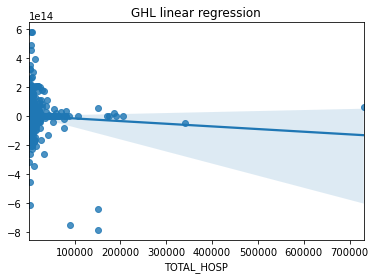

Mean squared error: 1561694989373106412087934976.00
Root Mean squared error: 39518286771735.27
Mean absolute error: 7574221294914.40
{'mape': 1714316055.059374, 'me': -168526113024.33005, 'mae': 7574221294914.389, 'mpe': -104067260.97185649, 'mse': 1.561694989373107e+27, 'rmse': 39518286771735.27, 'mmape': 6.045863111263806}


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


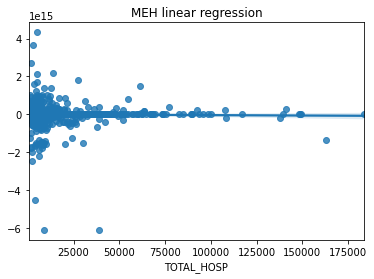

Mean squared error: 51639923792895928809474228224.00
Root Mean squared error: 227244194189633.66
Mean absolute error: 35492992594405.56
{'mape': 7696952078.684994, 'me': -2417603917893.5103, 'mae': 35492992594405.51, 'mpe': 5606890.832147657, 'mse': 5.163992379289592e+28, 'rmse': 227244194189633.62, 'mmape': 2.1361944635429633}


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


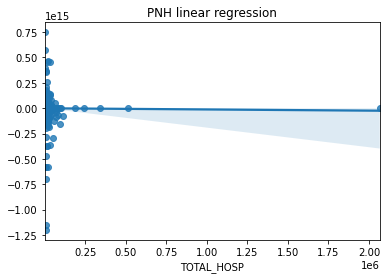

Mean squared error: 1807733696337265773108002816.00
Root Mean squared error: 42517451667959.43
Mean absolute error: 6051227475519.74
{'mape': 1189095261.5437822, 'me': -631517519908.79, 'mae': 6051227475519.745, 'mpe': 49962949.90168675, 'mse': 1.8077336963372666e+27, 'rmse': 42517451667959.44, 'mmape': 1.301770698381642}


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


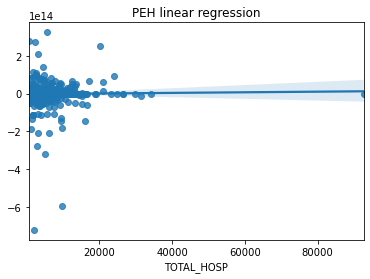

Mean squared error: 2086362052112684717453606912.00
Root Mean squared error: 45676712361034.53
Mean absolute error: 12163146214340.04
{'mape': 4020023843.1962, 'me': -1650536787418.2607, 'mae': 12163146214340.03, 'mpe': -429946899.7511808, 'mse': 2.0863620521126842e+27, 'rmse': 45676712361034.52, 'mmape': 2.8050274390156233}


In [15]:
for hosp in dict_df_train_X_new:
    model = LinearRegression(n_jobs=2)
    model.fit(dict_df_train_X_new[hosp], dict_df_train_y[hosp])

    # save model to file
    pickle.dump(model, open(f'{save_folder_path}/{hosp}_uc3_linreg_model_pkl.sav', 'wb'))
    
    y_pred = model.predict(dict_df_test_X_new[hosp])
    sns.regplot(dict_df_test_y[hosp],y_pred).set_title(f'{hosp} linear regression')
    plt.show()
    
    # MSE
    print('Mean squared error: %.2f'
          % mean_squared_error(dict_df_test_y[hosp],y_pred, squared=True))

    # RMSE
    print('Root Mean squared error: %.2f'
          % mean_squared_error(dict_df_test_y[hosp],y_pred, squared=False))

    # MAE
    print('Mean absolute error: %.2f'
          % mean_absolute_error(dict_df_test_y[hosp],y_pred))
    
    print(forecast_accuracy(y_pred, dict_df_test_y[hosp]))

Neural Networks ( Sequential )

In [16]:
n_hid_nodes = 4096
dropout_rate = 0.2
rand_seed = 42
kernel_init = 'he_normal'
hid_act = 'relu'
n_layers = 2
epoch=100

In [17]:
def NN_model_train(hosp):
    NN_model = Sequential(name=f'{hosp}_{n_layers+1}layers_{n_hid_nodes}_nodes')
    NN_model.add(Dense(n_hid_nodes,
                       kernel_initializer=kernel_init,
                       input_dim = dict_df_train_X_new[hosp].shape[1], 
                       activation=hid_act))
    NN_model.add(Dropout(dropout_rate,
                         seed=rand_seed))
    for i in range(n_layers):
        NN_model.add(Dense(n_hid_nodes, kernel_initializer=kernel_init))
        NN_model.add(BatchNormalization())
        NN_model.add(Activation(hid_act))
        NN_model.add(Dropout(dropout_rate, seed=rand_seed))
        
    NN_model.add(Dense(1, kernel_initializer=kernel_init,activation='linear'))
    
    NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
    print(NN_model.summary())
    
    checkpoint_name = hosp + '_NN2_Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
    checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    callbacks_list = [es, checkpoint]
    
    NN_model.fit(dict_df_train_X_new[hosp], dict_df_train_y[hosp],
                 epochs=100, batch_size=128, validation_split = 0.2,
                 callbacks=callbacks_list)

    # save model to file
    NN_model.save(f'{save_folder_path}/{hosp}_uc3_NN2_model.h5')
    
    predictions = NN_model.predict(dict_df_test_X_new[hosp])
    
    sns.regplot(x=dict_df_test_y[hosp], y=predictions).set_title(NN_model.name)
    plt.show()
    
    # MSE
    print('Mean squared error: %.2f'
          % mean_squared_error(dict_df_test_y[hosp],predictions, squared=True))

    # RMSE
    print('Root Mean squared error: %.2f'
          % mean_squared_error(dict_df_test_y[hosp],predictions, squared=False))

    # MAE
    print('Mean absolute error: %.2f'
          % mean_absolute_error(dict_df_test_y[hosp],predictions))
    
    print(forecast_accuracy(predictions.reshape((-1,)), dict_df_test_y[hosp]))

Model: "GHL_3layers_4096_nodes"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              27033600  
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
batch_normalization (BatchNo (None, 4096)              16384     
_________________________________________________________________
activation (Activation)      (None, 4096)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 4096)   

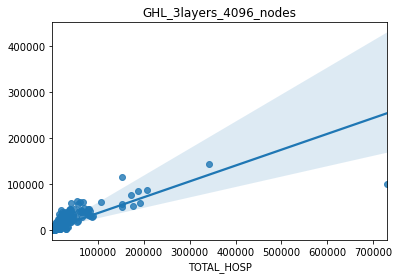

Mean squared error: 125437103.87
Root Mean squared error: 11199.87
Mean absolute error: 1819.52
{'mape': 0.26125498448390827, 'me': -987.9868395330633, 'mae': 1819.51561602608, 'mpe': 0.010641417055725137, 'mse': 125437103.87077206, 'rmse': 11199.870707770338, 'mmape': 0.29903143384455605}
Model: "MEH_3layers_4096_nodes"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 4096)              34152448  
_________________________________________________________________
dropout_3 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
batch_normalization_2 (Batch (None, 4096)              16384     
_________________________________________________________________
activation_2 (Act

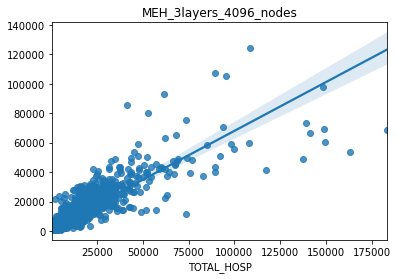

Mean squared error: 28834504.74
Root Mean squared error: 5369.78
Mean absolute error: 1990.70
{'mape': 0.2914038274468879, 'me': -685.3793226525376, 'mae': 1990.7021582633083, 'mpe': 0.05604568920994836, 'mse': 28834504.743964843, 'rmse': 5369.776973391432, 'mmape': 0.30503732700921693}
Model: "PNH_3layers_4096_nodes"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 4096)              33148928  
_________________________________________________________________
dropout_6 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
batch_normalization_4 (Batch (None, 4096)              16384     
_________________________________________________________________
activation_4 (Activa

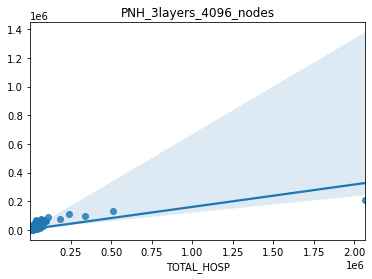

Mean squared error: 817519732.14
Root Mean squared error: 28592.30
Mean absolute error: 2496.22
{'mape': 0.31744635800185855, 'me': -849.4127286599397, 'mae': 2496.2192959203553, 'mpe': 0.1020233559058879, 'mse': 817519732.1377251, 'rmse': 28592.301973393558, 'mmape': 0.2990428362609111}
Model: "PEH_3layers_4096_nodes"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 4096)              11173888  
_________________________________________________________________
dropout_9 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
batch_normalization_6 (Batch (None, 4096)              16384     
_________________________________________________________________
activation_6 (Activ

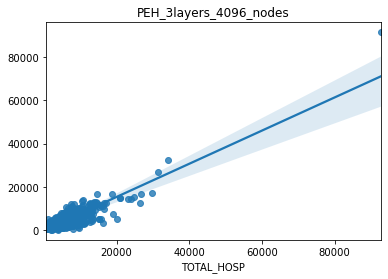

Mean squared error: 5641779.26
Root Mean squared error: 2375.24
Mean absolute error: 1499.48
{'mape': 0.30447682958510025, 'me': -1024.8169292496968, 'mae': 1499.4776521777542, 'mpe': -0.12515436688874593, 'mse': 5641779.261697162, 'rmse': 2375.2429900322118, 'mmape': 0.5154175439700052}


In [18]:
for hosp in dict_df_train_X_new:
    NN_model_train(hosp)

Random forest

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 96 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=-1)]: Done  11 out of 100 | elapsed:   24.5s remaining:  3.3min
[Parallel(n_jobs=-1)]: Done  62 out of 100 | elapsed:   40.8s remaining:   25.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   52.4s finished
[Parallel(n_jobs=96)]: Using backend ThreadingBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  11 out of 100 | elapsed:    1.0s remaining:    8.0s
[Parallel(n_jobs=96)]: Done  62 out of 100 | elapsed:    1.2s remaining:    0.7s
[Parallel(n_jobs=96)]: Done 100 out of 100 | elapsed:    1.2s finished
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


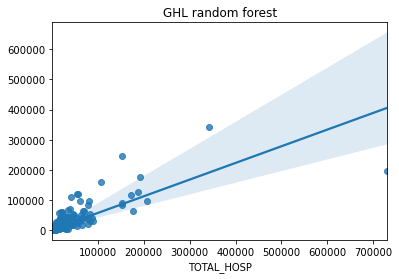

Mean squared error: 90306199.45
Root Mean squared error: 9502.96
Mean absolute error: 1957.23
{'mape': 0.3129581771248546, 'me': -536.5070705125654, 'mae': 1957.2345707564498, 'mpe': 0.09387623717255392, 'mse': 90306199.4452149, 'rmse': 9502.957405208912, 'mmape': 0.30244551034354566}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 96 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100building tree 20 of 100
building tree 21 of 100

building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
bu

[Parallel(n_jobs=-1)]: Done  11 out of 100 | elapsed:   53.4s remaining:  7.2min
[Parallel(n_jobs=-1)]: Done  62 out of 100 | elapsed:  1.1min remaining:   40.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=96)]: Using backend ThreadingBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  11 out of 100 | elapsed:    1.4s remaining:   11.3s
[Parallel(n_jobs=96)]: Done  62 out of 100 | elapsed:    1.5s remaining:    0.9s
[Parallel(n_jobs=96)]: Done 100 out of 100 | elapsed:    1.6s finished
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


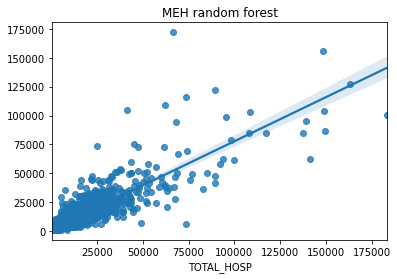

Mean squared error: 26931022.62
Root Mean squared error: 5189.51
Mean absolute error: 2170.91
{'mape': 0.33415164260101254, 'me': -450.37842199465223, 'mae': 2170.9122063677446, 'mpe': 0.11080041655822911, 'mse': 26931022.61766617, 'rmse': 5189.510826433082, 'mmape': 0.31727487731799636}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 96 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100building tree 9 of 100
building tree 10 of 100
building tree 11 of 100

building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=-1)]: Done  11 out of 100 | elapsed:   46.4s remaining:  6.3min
[Parallel(n_jobs=-1)]: Done  62 out of 100 | elapsed:   56.1s remaining:   34.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=96)]: Using backend ThreadingBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  11 out of 100 | elapsed:    0.4s remaining:    3.1s
[Parallel(n_jobs=96)]: Done  62 out of 100 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=96)]: Done 100 out of 100 | elapsed:    0.6s finished
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


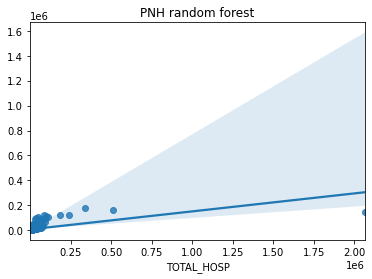

Mean squared error: 858300412.95
Root Mean squared error: 29296.76
Mean absolute error: 2680.71
{'mape': 0.34383576754341727, 'me': -819.0324886919187, 'mae': 2680.7113514183093, 'mpe': 0.11903880495544404, 'mse': 858300412.9460871, 'rmse': 29296.76454740501, 'mmape': 0.314296550048438}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 96 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=-1)]: Done  11 out of 100 | elapsed:    3.2s remaining:   25.6s
[Parallel(n_jobs=-1)]: Done  62 out of 100 | elapsed:    3.8s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.3s finished
[Parallel(n_jobs=96)]: Using backend ThreadingBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  11 out of 100 | elapsed:    1.3s remaining:   10.3s
[Parallel(n_jobs=96)]: Done  62 out of 100 | elapsed:    1.4s remaining:    0.8s
[Parallel(n_jobs=96)]: Done 100 out of 100 | elapsed:    1.4s finished
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


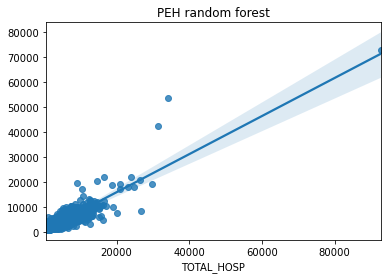

Mean squared error: 5323939.07
Root Mean squared error: 2307.37
Mean absolute error: 1392.19
{'mape': 0.32992868987756446, 'me': -349.17899076706453, 'mae': 1392.1939147564608, 'mpe': 0.0821252559922738, 'mse': 5323939.070279464, 'rmse': 2307.366262707216, 'mmape': 0.3247702256925905}


In [19]:
for hosp in dict_df_train_X_new:
    model = RandomForestRegressor(random_state=42, verbose=2, n_jobs=-1)
    model.fit(dict_df_train_X_new[hosp],dict_df_train_y[hosp])

    # save model to file
    pickle.dump(model, open(f'{save_folder_path}/{hosp}_uc3_rfreg_model_pkl.sav', 'wb'))
    
    predicted_forest = model.predict(dict_df_test_X_new[hosp])
    
    sns.regplot(dict_df_test_y[hosp],predicted_forest).set_title(f'{hosp} random forest')
    plt.show()
    
    # MSE
    print('Mean squared error: %.2f'
          % mean_squared_error(dict_df_test_y[hosp],predicted_forest, squared=True))

    # RMSE
    print('Root Mean squared error: %.2f'
          % mean_squared_error(dict_df_test_y[hosp],predicted_forest, squared=False))

    # MAE
    print('Mean absolute error: %.2f'
          % mean_absolute_error(dict_df_test_y[hosp],predicted_forest))
    
    print(forecast_accuracy(predicted_forest, dict_df_test_y[hosp]))

XG Boost

[17:46:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[17:46:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[17:46:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[17:46:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[17:46:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[17:47:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[17:47:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[17:47:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[17:47:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned no

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


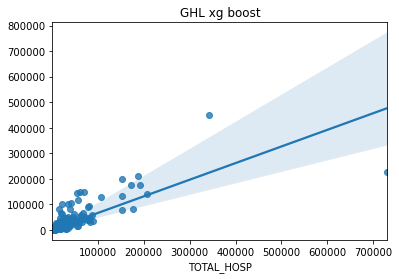

Mean squared error: 85087079.73
Root Mean squared error: 9224.27
Mean absolute error: 2010.67
{'mape': 0.3925345452526394, 'me': -119.48995839782094, 'mae': 2010.6733923669578, 'mpe': 0.1973166995254577, 'mse': 85087079.73353319, 'rmse': 9224.265809999904, 'mmape': 0.3288928418732659}
[17:59:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[17:59:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[17:59:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[18:00:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[18:00:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[18:00:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[18:00:27] INFO: ../src/tree/updater

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


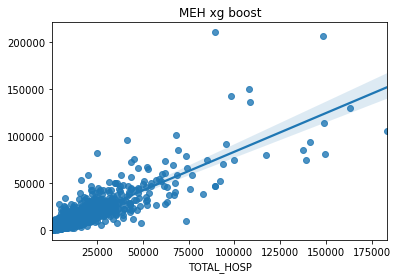

Mean squared error: 26819192.55
Root Mean squared error: 5178.72
Mean absolute error: 2318.90
{'mape': 0.4425059154050865, 'me': -27.649712874786182, 'mae': 2318.900752800713, 'mpe': 0.24206286432867113, 'mse': 26819192.554625854, 'rmse': 5178.724993145113, 'mmape': 0.3437012740469776}
[18:16:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[18:16:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[18:16:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[18:16:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[18:16:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[18:16:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[18:17:01] INFO: ../src/tree/update

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


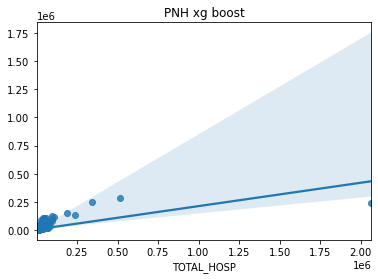

Mean squared error: 758107068.39
Root Mean squared error: 27533.74
Mean absolute error: 2732.63
{'mape': 0.44120853498206714, 'me': -250.89949209278114, 'mae': 2732.634467951165, 'mpe': 0.25696140206520207, 'mse': 758107068.3854227, 'rmse': 27533.7441766539, 'mmape': 0.32538101479386927}
[18:30:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[18:30:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[18:30:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[18:30:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[18:30:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[18:30:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[18:30:46] INFO: ../src/tree/upda

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


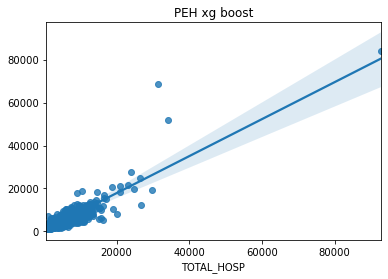

Mean squared error: 5509024.79
Root Mean squared error: 2347.13
Mean absolute error: 1348.06
{'mape': 0.3464408915612238, 'me': -81.12898780655887, 'mae': 1348.0565624563171, 'mpe': 0.1447901514064947, 'mse': 5509024.793620632, 'rmse': 2347.1311837263447, 'mmape': 0.3003733395033515}


In [20]:
for hosp in dict_df_train_X_new:
    XGBModel = XGBRegressor(random_state=42, verbosity=2, n_jobs=-1)
    XGBModel.fit(dict_df_train_X_new[hosp],dict_df_train_y[hosp] , verbose=True)

    # save model to file
    pickle.dump(model, open(f'{save_folder_path}/{hosp}_uc3_xgbreg_model_pkl.sav', 'wb'))
    
    XGBpredictions = XGBModel.predict(dict_df_test_X_new[hosp])
    
    sns.regplot(dict_df_test_y[hosp],XGBpredictions).set_title(f'{hosp} xg boost')
    plt.show()
    
    # MSE
    print('Mean squared error: %.2f'
          % mean_squared_error(dict_df_test_y[hosp],XGBpredictions, squared=True))

    # RMSE
    print('Root Mean squared error: %.2f'
          % mean_squared_error(dict_df_test_y[hosp],XGBpredictions, squared=False))

    # MAE
    print('Mean absolute error: %.2f'
          % mean_absolute_error(dict_df_test_y[hosp],XGBpredictions))
    
    print(forecast_accuracy(XGBpredictions, dict_df_test_y[hosp]))